In [12]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
pois_shapefile_path = "../data/raw/greater-london-latest-free.shp/gis_osm_pois_free_1.shp"
gdf_pois = gpd.read_file(pois_shapefile_path)

In [ ]:
business_fclasses  = [
    'pharmacy', 'doctors', 'dentist', 'theatre', 'nightclub', 'cinema', 'sports_centre', # leisure category
    'restaurant', 'fast_food', 'cafe', 'pub', 'bar', 'food_court', 'biergarten', # catering
    'hotel', 'motel', 'bed_and_breakfast', 'guesthouse', 'hostel', 'chalet', # accommodation
    'supermarket', 'bakery', 'kiosk', 'mall', 'department_store', 'general', # shopping
    'convenience', 'clothes', 'florist', 'chemist', 'bookshop', 'butcher', 
    'shoe_shop', 'beverages', 'optician', 'jeweller', 'gift_shop', 'sports_shop',
    'stationery', 'outdoor_shop', 'mobile_phone_shop', 'toy_shop', 'newsagent',
    'greengrocer', 'beauty_shop', 'video_shop', 'car_dealership', 'bicycle_shop',
    'doityourself', 'furniture_shop', 'computer_shop', 'garden_centre',
    'hairdresser', 'car_repair', 'car_rental', 'car_wash', 'car_sharing', 
    'bicycle_rental', 'travel_agent', 'laundry',
    'bank', 'atm', # money
]

In [14]:
# Example 3: Extract businesses based on a list of fclass types relevant to "business"
# You'll need to consult the PDF to create a comprehensive list of fclass values
# that you consider "businesses" (e.g., shops, offices, specific amenities).
# The 'pois' layer includes categories for shopping, catering, accommodation etc. [cite: 56, 61]

business_fclasses  = [
    'pharmacy', 'doctors', 'dentist', 'theatre', 'nightclub', 'cinema', 'sports_centre', # leisure category
    'restaurant', 'fast_food', 'cafe', 'pub', 'bar', 'food_court', 'biergarten', # catering
    'hotel', 'motel', 'bed_and_breakfast', 'guesthouse', 'hostel', 'chalet', # accommodation
    'supermarket', 'bakery', 'kiosk', 'mall', 'department_store', 'general', # shopping
    'convenience', 'clothes', 'florist', 'chemist', 'bookshop', 'butcher', 
    'shoe_shop', 'beverages', 'optician', 'jeweller', 'gift_shop', 'sports_shop',
    'stationery', 'outdoor_shop', 'mobile_phone_shop', 'toy_shop', 'newsagent',
    'greengrocer', 'beauty_shop', 'video_shop', 'car_dealership', 'bicycle_shop',
    'doityourself', 'furniture_shop', 'computer_shop', 'garden_centre',
    'hairdresser', 'car_repair', 'car_rental', 'car_wash', 'car_sharing', 
    'bicycle_rental', 'travel_agent', 'laundry',
    'bank', 'atm', # money
]

# Filter for multiple types of businesses
all_businesses = gdf_pois[gdf_pois['fclass'].isin(business_fclasses)]
print(f"Found {len(all_businesses)} businesses based on the defined list.")
# print(all_businesses.head())

Found 39688 businesses based on the defined list.


In [15]:
all_businesses

,osm_id,code,fclass,name,geometry
1,108539,2566,bicycle_rental,Windsor Terrace,POINT (-0.09339 51.52913)
3,451152,2304,pub,King of Prussia,POINT (-0.19461 51.60084)
4,451153,2301,restaurant,Central Restaurant,POINT (-0.1935 51.60203)
5,451154,2304,pub,The Catcher in the Rye,POINT (-0.19603 51.59958)
6,451271,2304,pub,The Tally Ho,POINT (-0.17656 51.6141)
...,...,...,...,...,...
94351,12818896780,2303,cafe,Station Coffee,POINT (-0.20501 51.53416)
94352,12819770592,2304,pub,The Crown,POINT (0.00473 51.48505)
94357,12820888010,2301,restaurant,Kish,POINT (-0.24901 51.51347)
94358,12821116746,2120,doctors,Central Park Surgery,POINT (0.05022 51.53258)


<Axes: xlabel='fclass'>

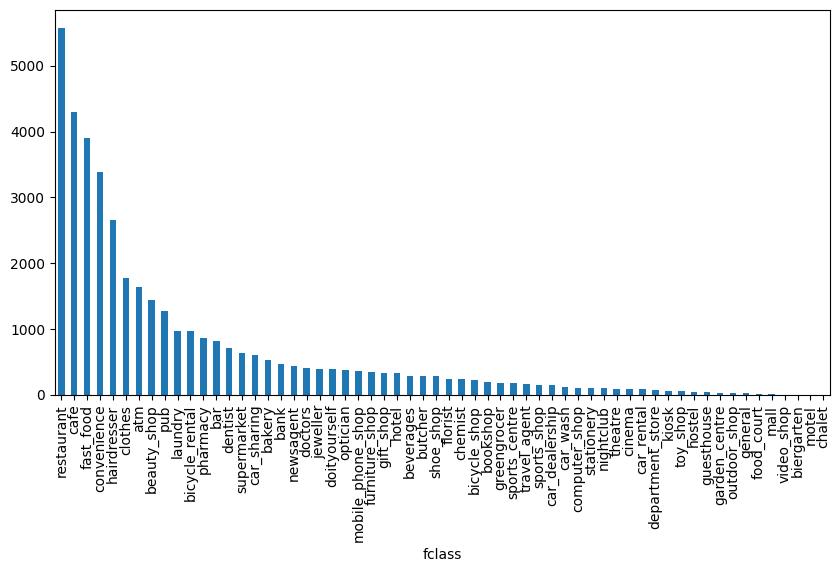

In [18]:
# plot a bar chard of the number of businesses by fclass
all_businesses['fclass'].value_counts().plot(kind='bar', figsize=(10, 5))


In [ ]:
roads_shp_path = "../data/raw/greater-london-latest-free.shp/gis_osm_roads_free_1.shp"
gdf_roads = gpd.read_file(roads_shp_path)
# Ensure roads also have the same CRS
# if gdf_roads.crs is None:
#     gdf_roads = gdf_roads.set_crs("EPSG:4326", allow_override=True)
# elif gdf_roads.crs != all_businesses.crs:
#     gdf_roads = gdf_roads.to_crs(all_businesses.crs)

# Perform a spatial join to find the nearest road.
# sjoin_nearest works best if your GeoPandas is version 0.10.0 or later.
# 'left' join keeps all businesses, finding the nearest road for each.
# 'max_distance' can be used to limit search radius (e.g., in meters if CRS is projected,
# or degrees if EPSG:4326 - be careful with degrees for distance)
# For EPSG:4326, a small degree value like 0.001 (approx 100m) might be a starting point.
# It's often better to reproject to a suitable projected CRS for distance-based operations.

# Reproject to a projected CRS for accurate distance (e.g., UTM zone for London)
# For London, a common UTM zone is EPSG:32630 (WGS 84 / UTM zone 30N)
all_businesses_proj = all_businesses.to_crs("EPSG:32630")
gdf_roads_proj = gdf_roads.to_crs("EPSG:32630")

businesses_with_streets = gpd.sjoin_nearest(
    all_businesses_proj,
    gdf_roads_proj[['geometry', 'name']], # Select only relevant columns from roads
    how='left',
    max_distance=100, # Max distance in CRS units (meters for EPSG:32630)
    lsuffix='business', # Suffix for overlapping column names from left GDF
    rsuffix='road'      # Suffix for overlapping column names from right GDF
)
# Rename the street name column if needed (it might be 'name_road')
if 'name_road' in businesses_with_streets.columns:
    businesses_with_streets = businesses_with_streets.rename(columns={'name_road': 'street_name'})
# Drop the index_road column if you don't need it
if 'index_road' in businesses_with_streets.columns:
    businesses_with_streets = businesses_with_streets.drop(columns=['index_road'])

# Convert back to original CRS if needed
businesses_with_streets = businesses_with_streets.to_crs(all_businesses.crs)
print("Street names added (or attempted).")
# print(businesses_with_streets.head())
all_businesses = businesses_with_streets.copy() # Update your main dataframe


Street names added (or attempted).


In [20]:
all_businesses

,osm_id,code,fclass,name_business,geometry,street_name
1,108539,2566,bicycle_rental,Windsor Terrace,POINT (-0.09339 51.52913),Windsor Terrace
3,451152,2304,pub,King of Prussia,POINT (-0.19461 51.60084),Dollis Park
4,451153,2301,restaurant,Central Restaurant,POINT (-0.1935 51.60203),Nether Street
5,451154,2304,pub,The Catcher in the Rye,POINT (-0.19603 51.59958),Regent's Park Road
6,451271,2304,pub,The Tally Ho,POINT (-0.17656 51.6141),None
...,...,...,...,...,...,...
94351,12818896780,2303,cafe,Station Coffee,POINT (-0.20501 51.53416),None
94352,12819770592,2304,pub,The Crown,POINT (0.00473 51.48505),Woodland Walk
94357,12820888010,2301,restaurant,Kish,POINT (-0.24901 51.51347),Old Oak Common Lane
94358,12821116746,2120,doctors,Central Park Surgery,POINT (0.05022 51.53258),Barking Road


In [ ]:
# Load the places shapefile (for suburbs, localities, etc.)
# ../data/raw/greater-london-latest-free.shp/gis_osm_pois_free_1.shp
places_shp_path = "../data/raw/greater-london-latest-free.shp/gis_osm_places_free_1.shp"
gdf_places = gpd.read_file(places_shp_path)
# Ensure places also have the same CRS
# if gdf_places.crs is None:
#     gdf_places = gdf_places.set_crs("EPSG:4326", allow_override=True)
# elif gdf_places.crs != all_businesses.crs:
#     gdf_places = gdf_places.to_crs(all_businesses.crs)

# Filter for relevant place types, e.g., suburbs, quarters, localities
# Consult the PDF (Section 4.1 'Places') for fclass values like 'suburb', 'locality'
relevant_places = gdf_places[gdf_places['fclass'].isin(['suburb', 'quarter', 'locality', 'hamlet', 'village'])]

# Perform a spatial join ('within' or 'intersects')
businesses_with_neighbourhood = gpd.sjoin(
    all_businesses, # Use the dataframe possibly already enriched with street names
    relevant_places[['geometry', 'name', 'fclass']],
    how='left',
    predicate='within', # or 'intersects'
    lsuffix='business',
    rsuffix='place'
)
if 'name_place' in businesses_with_neighbourhood.columns:
    businesses_with_neighbourhood = businesses_with_neighbourhood.rename(columns={'name_place': 'neighbourhood_name', 'fclass_place': 'neighbourhood_type'})
if 'index_place' in businesses_with_neighbourhood.columns:
        businesses_with_neighbourhood = businesses_with_neighbourhood.drop(columns=['index_place'])

print("Neighbourhood information added (or attempted).")
# print(businesses_with_neighbourhood.head())
all_businesses = businesses_with_neighbourhood.copy()

Neighbourhood information added (or attempted).


/var/folders/76/dl3rv17s7xz76wgx74llyccm0000gn/T/ipykernel_84655/2779331939.py:16: FutureWarning: Passing 'suffixes' which cause duplicate columns {'name_business'} in the result is deprecated and will raise a MergeError in a future version.
  businesses_with_neighbourhood = gpd.sjoin(


In [25]:
all_businesses

,osm_id,code,fclass_business,name_business,geometry,street_name,name_business,neighbourhood_type,neighbourhood_name,fclass
1,108539,2566,bicycle_rental,Windsor Terrace,POINT (-0.09339 51.52913),Windsor Terrace,NaN,NaN,NaN,NaN
3,451152,2304,pub,King of Prussia,POINT (-0.19461 51.60084),Dollis Park,NaN,NaN,NaN,NaN
4,451153,2301,restaurant,Central Restaurant,POINT (-0.1935 51.60203),Nether Street,NaN,NaN,NaN,NaN
5,451154,2304,pub,The Catcher in the Rye,POINT (-0.19603 51.59958),Regent's Park Road,NaN,NaN,NaN,NaN
6,451271,2304,pub,The Tally Ho,POINT (-0.17656 51.6141),None,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
94351,12818896780,2303,cafe,Station Coffee,POINT (-0.20501 51.53416),None,NaN,NaN,NaN,NaN
94352,12819770592,2304,pub,The Crown,POINT (0.00473 51.48505),Woodland Walk,NaN,NaN,NaN,NaN
94357,12820888010,2301,restaurant,Kish,POINT (-0.24901 51.51347),Old Oak Common Lane,NaN,NaN,NaN,NaN
94358,12821116746,2120,doctors,Central Park Surgery,POINT (0.05022 51.53258),Barking Road,NaN,NaN,NaN,NaN
